In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(2, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.dec3 = up_block(256, 128)
        self.dec2 = up_block(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, cover, secret):
        x = torch.cat((cover, secret), dim=1)
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d3 = self.dec3(e3)
        d2 = self.dec2(d3 + e2)

        out = torch.sigmoid(self.final(d2 + e1))
        return out

In [7]:
class SteganographyDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        cover, _ = self.dataset[idx]
        secret, _ = self.dataset[(idx + 1) % len(self.dataset)]

        # cover = cover.unsqueeze(0)
        # secret = secret.unsqueeze(0)

        return cover, secret


In [4]:
def calculate_bpp(secret, cover):
    total_secret_bits = secret.numel()
    total_pixels = cover.numel()
    return total_secret_bits / total_pixels

def calculate_mse(original, stego):
    return ((original - stego) ** 2).mean().item()

def calculate_psnr(original, stego):
    mse = calculate_mse(original, stego)
    max_pixel = 1.0
    return 10 * np.log10(max_pixel**2 / mse)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = MNIST(root="./data", train=True, download=True, transform=transform)
dataset = SteganographyDataset(train_data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.20MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 64.9kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.12MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [41]:
# model = UNet().cuda()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training the model
# epochs = 5
# metrics = {"psnr": [], "mse": [], "bpp": []}
# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0
#     epoch_psnr = []
#     epoch_mse = []
#     epoch_bpp = []

#     for cover, secret in dataloader:
#         cover, secret = cover.cuda(), secret.cuda()

#         optimizer.zero_grad()
#         stego = model(cover, secret)
#         loss = criterion(stego, cover)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#         # Calculate metrics for each batch
#         bpp = calculate_bpp(secret, cover)
#         mse = calculate_mse(cover.cpu().numpy(), stego.cpu().detach().numpy())
#         psnr = calculate_psnr(cover.cpu().numpy(), stego.cpu().detach().numpy())

#         epoch_bpp.append(bpp)
#         epoch_mse.append(mse)
#         epoch_psnr.append(psnr)

#     # Average metrics for the epoch
#     metrics["bpp"].append(np.mean(epoch_bpp))
#     metrics["mse"].append(np.mean(epoch_mse))
#     metrics["psnr"].append(np.mean(epoch_psnr))

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}, PSNR: {np.mean(epoch_psnr):.4f}, MSE: {np.mean(epoch_mse):.4f}, BPP: {np.mean(epoch_bpp):.4f}")

# # Testing and visualization

In [42]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# import matplotlib.pyplot as plt
# import numpy as np
# from tqdm import tqdm

# # Set random seed for reproducibility
# torch.manual_seed(42)

# # Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the U-Net architecture
# class UNetSteganography(nn.Module):
#     def __init__(self):
#         super(UNetSteganography, self).__init__()

#         # Encoder
#         self.enc_conv1 = nn.Conv2d(2, 64, 3, padding=1)  # 2 channels: cover + secret
#         self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)

#         # Decoder
#         self.dec_conv1 = nn.Conv2d(256, 128, 3, padding=1)
#         self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
#         self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)  # Output: stego image

#         # Reveal Network
#         self.rev_conv1 = nn.Conv2d(1, 64, 3, padding=1)  # Input: stego image
#         self.rev_conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.rev_conv3 = nn.Conv2d(128, 1, 3, padding=1)  # Output: revealed secret

#         self.pool = nn.MaxPool2d(2, 2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.relu = nn.ReLU()

#     def forward(self, cover, secret):
#         # Prepare input
#         x = torch.cat([cover, secret], dim=1)

#         # Encoding
#         e1 = self.relu(self.enc_conv1(x))
#         e2 = self.relu(self.enc_conv2(self.pool(e1)))
#         e3 = self.relu(self.enc_conv3(self.pool(e2)))

#         # Decoding
#         d1 = self.relu(self.dec_conv1(self.upsample(e3)))
#         d2 = self.relu(self.dec_conv2(self.upsample(d1)))
#         stego = torch.sigmoid(self.dec_conv3(d2))

#         # Reveal
#         r1 = self.relu(self.rev_conv1(stego))
#         r2 = self.relu(self.rev_conv2(r1))
#         revealed = torch.sigmoid(self.rev_conv3(r2))

#         return stego, revealed

# # Prepare data
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Initialize model, loss function, and optimizer
# model = UNetSteganography().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training function
# def train(model, dataloader, criterion, optimizer, num_epochs):
#     model.train()
#     metrics_history = {'train_loss': [], 'psnr': [], 'mse': [], 'bpp': []}

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         running_mse = 0.0
#         running_psnr = 0.0

#         for i, (cover_imgs, _) in enumerate(tqdm(dataloader)):
#             # Get a different batch for secret images
#             secret_imgs, _ = next(iter(DataLoader(train_dataset, batch_size=cover_imgs.shape[0], shuffle=True)))

#             cover_imgs = cover_imgs.to(device)
#             secret_imgs = secret_imgs.to(device)

#             optimizer.zero_grad()

#             # Forward pass
#             stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)

#             # Calculate losses
#             loss_cover = criterion(stego_imgs, cover_imgs)
#             loss_secret = criterion(revealed_imgs, secret_imgs)
#             total_loss = loss_cover + loss_secret

#             # Backward pass
#             total_loss.backward()
#             optimizer.step()

#             # Calculate metrics
#             mse = torch.mean((stego_imgs - cover_imgs) ** 2).item()
#             psnr = 10 * torch.log10(1 / mse).item() if mse > 0 else float('inf')

#             running_loss += total_loss.item()
#             running_mse += mse
#             running_psnr += psnr

#         # Calculate average metrics for the epoch
#         avg_loss = running_loss / len(dataloader)
#         avg_mse = running_mse / len(dataloader)
#         avg_psnr = running_psnr / len(dataloader)

#         # Calculate BPP (assuming 28x28 MNIST images)
#         bpp = 784 / (28 * 28)  # Each pixel in secret image contributes 1 bit

#         metrics_history['train_loss'].append(avg_loss)
#         metrics_history['mse'].append(avg_mse)
#         metrics_history['psnr'].append(avg_psnr)
#         metrics_history['bpp'].append(bpp)

#         print(f'Epoch {epoch+1}/{num_epochs}:')
#         print(f'Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, PSNR: {avg_psnr:.2f} dB, BPP: {bpp:.2f}')

#     return metrics_history

# # Function to visualize results
# def visualize_results(model, dataloader):
#     model.eval()
#     with torch.no_grad():
#         cover_imgs, _ = next(iter(dataloader))
#         secret_imgs, _ = next(iter(DataLoader(train_dataset, batch_size=cover_imgs.shape[0], shuffle=True)))

#         cover_imgs = cover_imgs.to(device)
#         secret_imgs = secret_imgs.to(device)

#         stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)

#         # Convert tensors to numpy arrays for visualization
#         cover_imgs = cover_imgs.cpu().numpy()
#         secret_imgs = secret_imgs.cpu().numpy()
#         stego_imgs = stego_imgs.cpu().numpy()
#         revealed_imgs = revealed_imgs.cpu().numpy()

#         # Plot results
#         fig, axes = plt.subplots(4, 4, figsize=(15, 15))

#         for i in range(4):
#             # Original cover image
#             axes[i][0].imshow(cover_imgs[i][0], cmap='gray')
#             axes[i][0].set_title('Cover Image')
#             axes[i][0].axis('off')

#             # Secret image
#             axes[i][1].imshow(secret_imgs[i][0], cmap='gray')
#             axes[i][1].set_title('Secret Image')
#             axes[i][1].axis('off')

#             # Stego image
#             axes[i][2].imshow(stego_imgs[i][0], cmap='gray')
#             axes[i][2].set_title('Stego Image')
#             axes[i][2].axis('off')

#             # Revealed secret image
#             axes[i][3].imshow(revealed_imgs[i][0], cmap='gray')
#             axes[i][3].set_title('Revealed Secret')
#             axes[i][3].axis('off')

#         plt.tight_layout()
#         plt.show()

# # Function to plot training metrics
# def plot_metrics(metrics_history):
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#     # Plot loss
#     axes[0][0].plot(metrics_history['train_loss'])
#     axes[0][0].set_title('Training Loss')
#     axes[0][0].set_xlabel('Epoch')
#     axes[0][0].set_ylabel('Loss')

#     # Plot MSE
#     axes[0][1].plot(metrics_history['mse'])
#     axes[0][1].set_title('Mean Square Error')
#     axes[0][1].set_xlabel('Epoch')
#     axes[0][1].set_ylabel('MSE')

#     # Plot PSNR
#     axes[1][0].plot(metrics_history['psnr'])
#     axes[1][0].set_title('Peak Signal to Noise Ratio')
#     axes[1][0].set_xlabel('Epoch')
#     axes[1][0].set_ylabel('PSNR (dB)')

#     # Plot BPP
#     axes[1][1].plot(metrics_history['bpp'])
#     axes[1][1].set_title('Bits Per Pixel')
#     axes[1][1].set_xlabel('Epoch')
#     axes[1][1].set_ylabel('BPP')

#     plt.tight_layout()
#     plt.show()

# # Train the model
# num_epochs = 10
# metrics_history = train(model, train_loader, criterion, optimizer, num_epochs)

# # Visualize results
# visualize_results(model, train_loader)

# # Plot training metrics
# plot_metrics(metrics_history)

In [10]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# import matplotlib.pyplot as plt
# import numpy as np
# from tqdm import tqdm


In [11]:
# # Set random seed for reproducibility
# torch.manual_seed(42)

# # Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:
# class UNetSteganography(nn.Module):
#     def __init__(self):
#         super(UNetSteganography, self).__init__()

#         # Encoder
#         self.enc_conv1 = nn.Conv2d(2, 64, 3, padding=1)  # 2 channels: cover + secret
#         self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.enc_conv3 = nn.Conv2d(128, 256, 3, padding=1)

#         # Decoder
#         self.dec_conv1 = nn.Conv2d(256, 128, 3, padding=1)
#         self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
#         self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)  # Output: stego image

#         # Reveal Network
#         self.rev_conv1 = nn.Conv2d(1, 64, 3, padding=1)  # Input: stego image
#         self.rev_conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.rev_conv3 = nn.Conv2d(128, 1, 3, padding=1)  # Output: revealed secret

#         self.pool = nn.MaxPool2d(2, 2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.relu = nn.ReLU()

#     def forward(self, cover, secret):
#         # Prepare input
#         x = torch.cat([cover, secret], dim=1)

#         # Encoding
#         e1 = self.relu(self.enc_conv1(x))
#         e2 = self.relu(self.enc_conv2(self.pool(e1)))
#         e3 = self.relu(self.enc_conv3(self.pool(e2)))

#         # Decoding
#         d1 = self.relu(self.dec_conv1(self.upsample(e3)))
#         d2 = self.relu(self.dec_conv2(self.upsample(d1)))
#         stego = torch.sigmoid(self.dec_conv3(d2))

#         # Reveal
#         r1 = self.relu(self.rev_conv1(stego))
#         r2 = self.relu(self.rev_conv2(r1))
#         revealed = torch.sigmoid(self.rev_conv3(r2))

#         return stego, revealed


In [24]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Initialize model, loss function, and optimizer
# model = UNetSteganography().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)


In [25]:
# def train(model, dataloader, criterion, optimizer, num_epochs):
#     model.train()
#     metrics_history = {'train_loss': [], 'psnr': [], 'mse': [], 'bpp': []}

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         running_mse = 0.0
#         running_psnr = 0.0

#         for i, (cover_imgs, _) in enumerate(tqdm(dataloader)):
#             # Get a different batch for secret images
#             secret_imgs, _ = next(iter(DataLoader(train_dataset, batch_size=cover_imgs.shape[0], shuffle=True)))

#             cover_imgs = cover_imgs.to(device)
#             secret_imgs = secret_imgs.to(device)

#             optimizer.zero_grad()

#             # Forward pass
#             stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)

#             # Calculate losses
#             loss_cover = criterion(stego_imgs, cover_imgs)
#             loss_secret = criterion(revealed_imgs, secret_imgs)
#             total_loss = loss_cover + loss_secret

#             # Backward pass
#             total_loss.backward()
#             optimizer.step()

#             # Calculate metrics
#           # Calculate metrics
#             mse = torch.mean((stego_imgs - cover_imgs) ** 2) # Remove .item() to keep it a tensor
#             psnr = 10 * torch.log10(1 / mse) if mse > 0 else float('inf') # Calculate with tensors
#             psnr = psnr.item() if mse > 0 else float('inf')

#             running_loss += total_loss.item()
#             running_mse += mse
#             running_psnr += psnr

#         # Calculate average metrics for the epoch
#         avg_loss = running_loss / len(dataloader)
#         avg_mse = running_mse / len(dataloader)
#         avg_psnr = running_psnr / len(dataloader)

#         # Calculate BPP (assuming 28x28 MNIST images)
#         bpp = 784 / (28 * 28)  # Each pixel in secret image contributes 1 bit

#         metrics_history['train_loss'].append(avg_loss)
#         metrics_history['mse'].append(avg_mse)
#         metrics_history['psnr'].append(avg_psnr)
#         metrics_history['bpp'].append(bpp)

#         print(f'Epoch {epoch+1}/{num_epochs}:')
#         print(f'Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, PSNR: {avg_psnr:.2f} dB, BPP: {bpp:.2f}')

#     return metrics_history

In [43]:
# num_epochs = 20
# metrics_history = train(model, train_loader, criterion, optimizer, num_epochs)

In [18]:
# def visualize_results(model, dataloader):
#     model.eval()
#     with torch.no_grad():
#         cover_imgs, _ = next(iter(dataloader))
#         secret_imgs, _ = next(iter(DataLoader(train_dataset, batch_size=cover_imgs.shape[0], shuffle=True)))

#         cover_imgs = cover_imgs.to(device)
#         secret_imgs = secret_imgs.to(device)

#         stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)

#         # Convert tensors to numpy arrays for visualization
#         cover_imgs = cover_imgs.cpu().numpy()
#         secret_imgs = secret_imgs.cpu().numpy()
#         stego_imgs = stego_imgs.cpu().numpy()
#         revealed_imgs = revealed_imgs.cpu().numpy()

#         # Plot results
#         fig, axes = plt.subplots(4, 4, figsize=(15, 15))

#         for i in range(4):
#             # Original cover image
#             axes[i][0].imshow(cover_imgs[i][0], cmap='gray')
#             axes[i][0].set_title('Cover Image')
#             axes[i][0].axis('off')

#             # Secret image
#             axes[i][1].imshow(secret_imgs[i][0], cmap='gray')
#             axes[i][1].set_title('Secret Image')
#             axes[i][1].axis('off')

#             # Stego image
#             axes[i][2].imshow(stego_imgs[i][0], cmap='gray')
#             axes[i][2].set_title('Stego Image')
#             axes[i][2].axis('off')

#             # Revealed secret image
#             axes[i][3].imshow(revealed_imgs[i][0], cmap='gray')
#             axes[i][3].set_title('Revealed Secret')
#             axes[i][3].axis('off')

#         plt.tight_layout()
#         plt.show()

# # Function to plot training metrics
# def plot_metrics(metrics_history):
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#     # Plot loss
#     axes[0][0].plot(metrics_history['train_loss'])
#     axes[0][0].set_title('Training Loss')
#     axes[0][0].set_xlabel('Epoch')
#     axes[0][0].set_ylabel('Loss')

#     # Plot MSE
#     axes[0][1].plot(metrics_history['mse'])
#     axes[0][1].set_title('Mean Square Error')
#     axes[0][1].set_xlabel('Epoch')
#     axes[0][1].set_ylabel('MSE')

#     # Plot PSNR
#     axes[1][0].plot(metrics_history['psnr'])
#     axes[1][0].set_title('Peak Signal to Noise Ratio')
#     axes[1][0].set_xlabel('Epoch')
#     axes[1][0].set_ylabel('PSNR (dB)')

#     # Plot BPP
#     axes[1][1].plot(metrics_history['bpp'])
#     axes[1][1].set_title('Bits Per Pixel')
#     axes[1][1].set_xlabel('Epoch')
#     axes[1][1].set_ylabel('BPP')

#     plt.tight_layout()
#     plt.show()

In [22]:
# def plot_metrics(metrics_history):
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#     # Plot loss
#     axes[0][0].plot(metrics_history['train_loss'])
#     axes[0][0].set_title('Training Loss')
#     axes[0][0].set_xlabel('Epoch')
#     axes[0][0].set_ylabel('Loss')

#     # Plot MSE
#     # Move mse values to CPU and convert to NumPy array
#     mse_values = [mse.detach().cpu().numpy() for mse in metrics_history['mse']]
#     axes[0][1].plot(mse_values)
#     axes[0][1].set_title('Mean Square Error')
#     axes[0][1].set_xlabel('Epoch')
#     axes[0][1].set_ylabel('MSE')

#     # Plot PSNR
#     axes[1][0].plot(metrics_history['psnr'])
#     axes[1][0].set_title('Peak Signal to Noise Ratio')
#     axes[1][0].set_xlabel('Epoch')
#     axes[1][0].set_ylabel('PSNR (dB)')

#     # Plot BPP
#     axes[1][1].plot(metrics_history['bpp'])
#     axes[1][1].set_title('Bits Per Pixel')
#     axes[1][1].set_xlabel('Epoch')
#     axes[1][1].set_ylabel('BPP')

#     plt.tight_layout()
#     plt.show()

In [44]:
# # Visualize results
# visualize_results(model, train_loader)

# # Plot training metrics
# plot_metrics(metrics_history)

In [27]:
# class UNetSteganography(nn.Module):
#     def __init__(self):
#         super(UNetSteganography, self).__init__()

#         # Encoder
#         self.enc_conv1 = nn.Sequential(
#             nn.Conv2d(2, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
#         self.enc_conv2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True)
#         )
#         self.enc_conv3 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True)
#         )

#         # Decoder
#         self.dec_conv1 = nn.Sequential(
#             nn.Conv2d(256, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True)
#         )
#         self.dec_conv2 = nn.Sequential(
#             nn.Conv2d(128, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
#         self.dec_conv3 = nn.Sequential(
#             nn.Conv2d(64, 1, 3, padding=1),
#             nn.Sigmoid()  # Ensure output is between 0 and 1
#         )

#         # Reveal Network (made deeper)
#         self.rev_conv1 = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
#         self.rev_conv2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True)
#         )
#         self.rev_conv3 = nn.Sequential(
#             nn.Conv2d(128, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
#         self.rev_conv4 = nn.Sequential(
#             nn.Conv2d(64, 1, 3, padding=1),
#             nn.Sigmoid()
#         )

#         self.pool = nn.MaxPool2d(2, 2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#     def forward(self, cover, secret):
#         # Normalize inputs
#         cover = cover / 255.0 if cover.max() > 1 else cover
#         secret = secret / 255.0 if secret.max() > 1 else secret

#         # Prepare input
#         x = torch.cat([cover, secret], dim=1)

#         # Encoding with skip connections
#         e1 = self.enc_conv1(x)
#         e2 = self.enc_conv2(self.pool(e1))
#         e3 = self.enc_conv3(self.pool(e2))

#         # Decoding with skip connections
#         d1 = self.dec_conv1(self.upsample(e3))
#         d1 = d1 + e2  # Skip connection
#         d2 = self.dec_conv2(self.upsample(d1))
#         d2 = d2 + e1  # Skip connection
#         stego = self.dec_conv3(d2)

#         # Reveal
#         r1 = self.rev_conv1(stego)
#         r2 = self.rev_conv2(r1)
#         r3 = self.rev_conv3(r2)
#         revealed = self.rev_conv4(r3)

#         return stego, revealed


In [33]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [34]:
# model = UNetSteganography().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate

# # Training function with beta parameter for loss balance
# def train(model, dataloader, criterion, optimizer, num_epochs, beta=0.75):
#     model.train()
#     metrics_history = {'train_loss': [], 'psnr': [], 'mse': [], 'bpp': []}

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         running_mse = 0.0
#         running_psnr = 0.0

#         for i, (cover_imgs, _) in enumerate(tqdm(dataloader)):
#             # Get a different batch for secret images
#             secret_imgs, _ = next(iter(DataLoader(train_dataset, batch_size=cover_imgs.shape[0], shuffle=True)))

#             cover_imgs = cover_imgs.to(device)
#             secret_imgs = secret_imgs.to(device)

#             optimizer.zero_grad()

#             # Forward pass
#             stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)

#             # Calculate losses with beta parameter
#             loss_cover = criterion(stego_imgs, cover_imgs)
#             loss_secret = criterion(revealed_imgs, secret_imgs)
#             total_loss = beta * loss_cover + (1 - beta) * loss_secret

#             # Backward pass
#             total_loss.backward()

#             # Gradient clipping to prevent exploding gradients
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#             optimizer.step()

#             # Calculate metrics
#             mse = torch.mean((stego_imgs - cover_imgs) ** 2)  # Keep mse as a tensor
#             psnr = 10 * torch.log10(1.0 / mse) if mse > 0 else float('inf')  # Calculate with tensors
#             psnr = psnr.item() if mse > 0 else float('inf')

#             running_loss += total_loss.item()
#             running_mse += mse
#             running_psnr += psnr

#         # Calculate average metrics for the epoch
#         avg_loss = running_loss / len(dataloader)
#         avg_mse = running_mse / len(dataloader)
#         avg_psnr = running_psnr / len(dataloader)

#         # Calculate BPP (assuming 28x28 MNIST images)
#         bpp = 784 / (28 * 28)  # Each pixel in secret image contributes 1 bit

#         metrics_history['train_loss'].append(avg_loss)
#         metrics_history['mse'].append(avg_mse)
#         metrics_history['psnr'].append(avg_psnr)
#         metrics_history['bpp'].append(bpp)

#         print(f'Epoch {epoch+1}/{num_epochs}:')
#         print(f'Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, PSNR: {avg_psnr:.2f} dB, BPP: {bpp:.2f}')

#     return metrics_history

In [45]:
# num_epochs = 10  # Increased number of epochs
# metrics_history = train(model, train_loader, criterion, optimizer, num_epochs)

100%|██████████| 938/938 [00:45<00:00, 20.49it/s]


Epoch [1/5], Loss: 3.6351, MSE: 1.9734, PSNR: 28.24


100%|██████████| 938/938 [00:45<00:00, 20.68it/s]


Epoch [2/5], Loss: 1.2279, MSE: 0.7748, PSNR: 30.86


100%|██████████| 938/938 [00:45<00:00, 20.65it/s]


Epoch [3/5], Loss: 0.9568, MSE: 0.6016, PSNR: 31.95


100%|██████████| 938/938 [00:45<00:00, 20.69it/s]


Epoch [4/5], Loss: 0.8130, MSE: 0.5040, PSNR: 32.73


100%|██████████| 938/938 [00:45<00:00, 20.62it/s]


Epoch [5/5], Loss: 0.7089, MSE: 0.4306, PSNR: 33.41
Test Results - MSE: 0.0004, PSNR: 33.78 dB, BPP: 1.0000


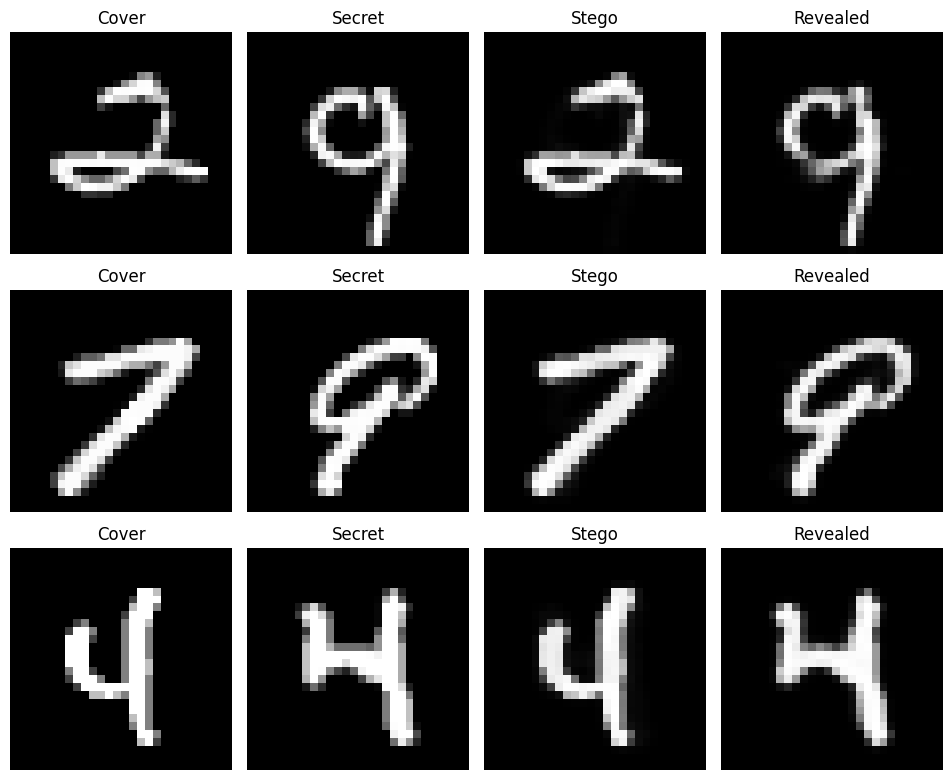

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the UNetSteganography class
class UNetSteganography(nn.Module):
    def __init__(self):
        super(UNetSteganography, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Decoder
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )
        # Reveal Network
        self.rev_conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.rev_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.rev_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.rev_conv4 = nn.Sequential(
            nn.Conv2d(64, 1, 3, padding=1),
            nn.Sigmoid()
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, cover, secret):
        cover = cover / 255.0 if cover.max() > 1 else cover
        secret = secret / 255.0 if secret.max() > 1 else secret
        x = torch.cat([cover, secret], dim=1)
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(self.pool(e1))
        e3 = self.enc_conv3(self.pool(e2))
        d1 = self.dec_conv1(self.upsample(e3)) + e2
        d2 = self.dec_conv2(self.upsample(d1)) + e1
        stego = self.dec_conv3(d2)
        r1 = self.rev_conv1(stego)
        r2 = self.rev_conv2(r1)
        r3 = self.rev_conv3(r2)
        revealed = self.rev_conv4(r3)
        return stego, revealed

# Metrics functions
def calculate_mse(original, reconstructed):
    return ((original - reconstructed) ** 2).mean()

def calculate_psnr(original, reconstructed):
    mse = calculate_mse(original, reconstructed)
    return 10 * torch.log10(1.0 / mse) if mse > 0 else float('inf')

def calculate_bpp(secret, cover):
    total_secret_bits = secret.numel()
    total_cover_pixels = cover.numel()
    return total_secret_bits / total_cover_pixels

# Training function
def train(model, dataloader, criterion, optimizer, num_epochs, beta=0.75):
    model.train()
    for epoch in range(num_epochs):
        running_loss, running_mse, running_psnr = 0.0, 0.0, 0.0
        # Create an iterator for secret images that has the same length as the dataloader
        secret_iter = iter(dataloader)
        for cover_imgs, _ in tqdm(dataloader):
            try:
                # Get the next batch of secret images
                secret_imgs, _ = next(secret_iter)
            except StopIteration:
                # Reset the iterator if it reaches the end
                secret_iter = iter(dataloader)
                secret_imgs, _ = next(secret_iter)
            cover_imgs, secret_imgs = cover_imgs.to(device), secret_imgs.to(device)
            optimizer.zero_grad()
            stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)
            loss_cover = criterion(stego_imgs, cover_imgs)
            loss_secret = criterion(revealed_imgs, secret_imgs)
            total_loss = beta * loss_cover + (1 - beta) * loss_secret
            total_loss.backward()
            optimizer.step()
            mse = calculate_mse(stego_imgs, cover_imgs)
            psnr = calculate_psnr(stego_imgs, cover_imgs)
            running_loss += total_loss.item()
            running_mse += mse.item()
            running_psnr += psnr
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, MSE: {running_mse:.4f}, PSNR: {running_psnr / len(dataloader):.2f}")
# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, optimizer, and loss function
model = UNetSteganography().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
train(model, train_loader, criterion, optimizer, num_epochs)

# Test steganography
model.eval()
cover_imgs, _ = next(iter(train_loader))
secret_imgs, _ = next(iter(train_loader))
cover_imgs, secret_imgs = cover_imgs.to(device), secret_imgs.to(device)
with torch.no_grad():
    stego_imgs, revealed_imgs = model(cover_imgs, secret_imgs)
mse = calculate_mse(stego_imgs, cover_imgs)
psnr = calculate_psnr(stego_imgs, cover_imgs)
bpp = calculate_bpp(secret_imgs, cover_imgs)
print(f"Test Results - MSE: {mse:.4f}, PSNR: {psnr:.2f} dB, BPP: {bpp:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 5, i * 5 + 1)
    plt.imshow(cover_imgs[i].cpu().squeeze(), cmap='gray')
    plt.title("Cover")
    plt.axis('off')
    plt.subplot(3, 5, i * 5 + 2)
    plt.imshow(secret_imgs[i].cpu().squeeze(), cmap='gray')
    plt.title("Secret")
    plt.axis('off')
    plt.subplot(3, 5, i * 5 + 3)
    plt.imshow(stego_imgs[i].cpu().squeeze(), cmap='gray')
    plt.title("Stego")
    plt.axis('off')
    plt.subplot(3, 5, i * 5 + 4)
    plt.imshow(revealed_imgs[i].cpu().squeeze(), cmap='gray')
    plt.title("Revealed")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [39]:
def plot_metrics(metrics_history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot loss
    axes[0][0].plot(metrics_history['train_loss'])
    axes[0][0].set_title('Training Loss')
    axes[0][0].set_xlabel('Epoch')
    axes[0][0].set_ylabel('Loss')

    # Plot MSE
    # Move mse values to CPU and convert to NumPy array
    mse_values = [mse.detach().cpu().numpy() for mse in metrics_history['mse']]
    axes[0][1].plot(mse_values)
    axes[0][1].set_title('Mean Square Error')
    axes[0][1].set_xlabel('Epoch')
    axes[0][1].set_ylabel('MSE')

    # Plot PSNR
    axes[1][0].plot(metrics_history['psnr'])
    axes[1][0].set_title('Peak Signal to Noise Ratio')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].set_ylabel('PSNR (dB)')

    # Plot BPP
    axes[1][1].plot(metrics_history['bpp'])
    axes[1][1].set_title('Bits Per Pixel')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].set_ylabel('BPP')

    plt.tight_layout()
    plt.show()

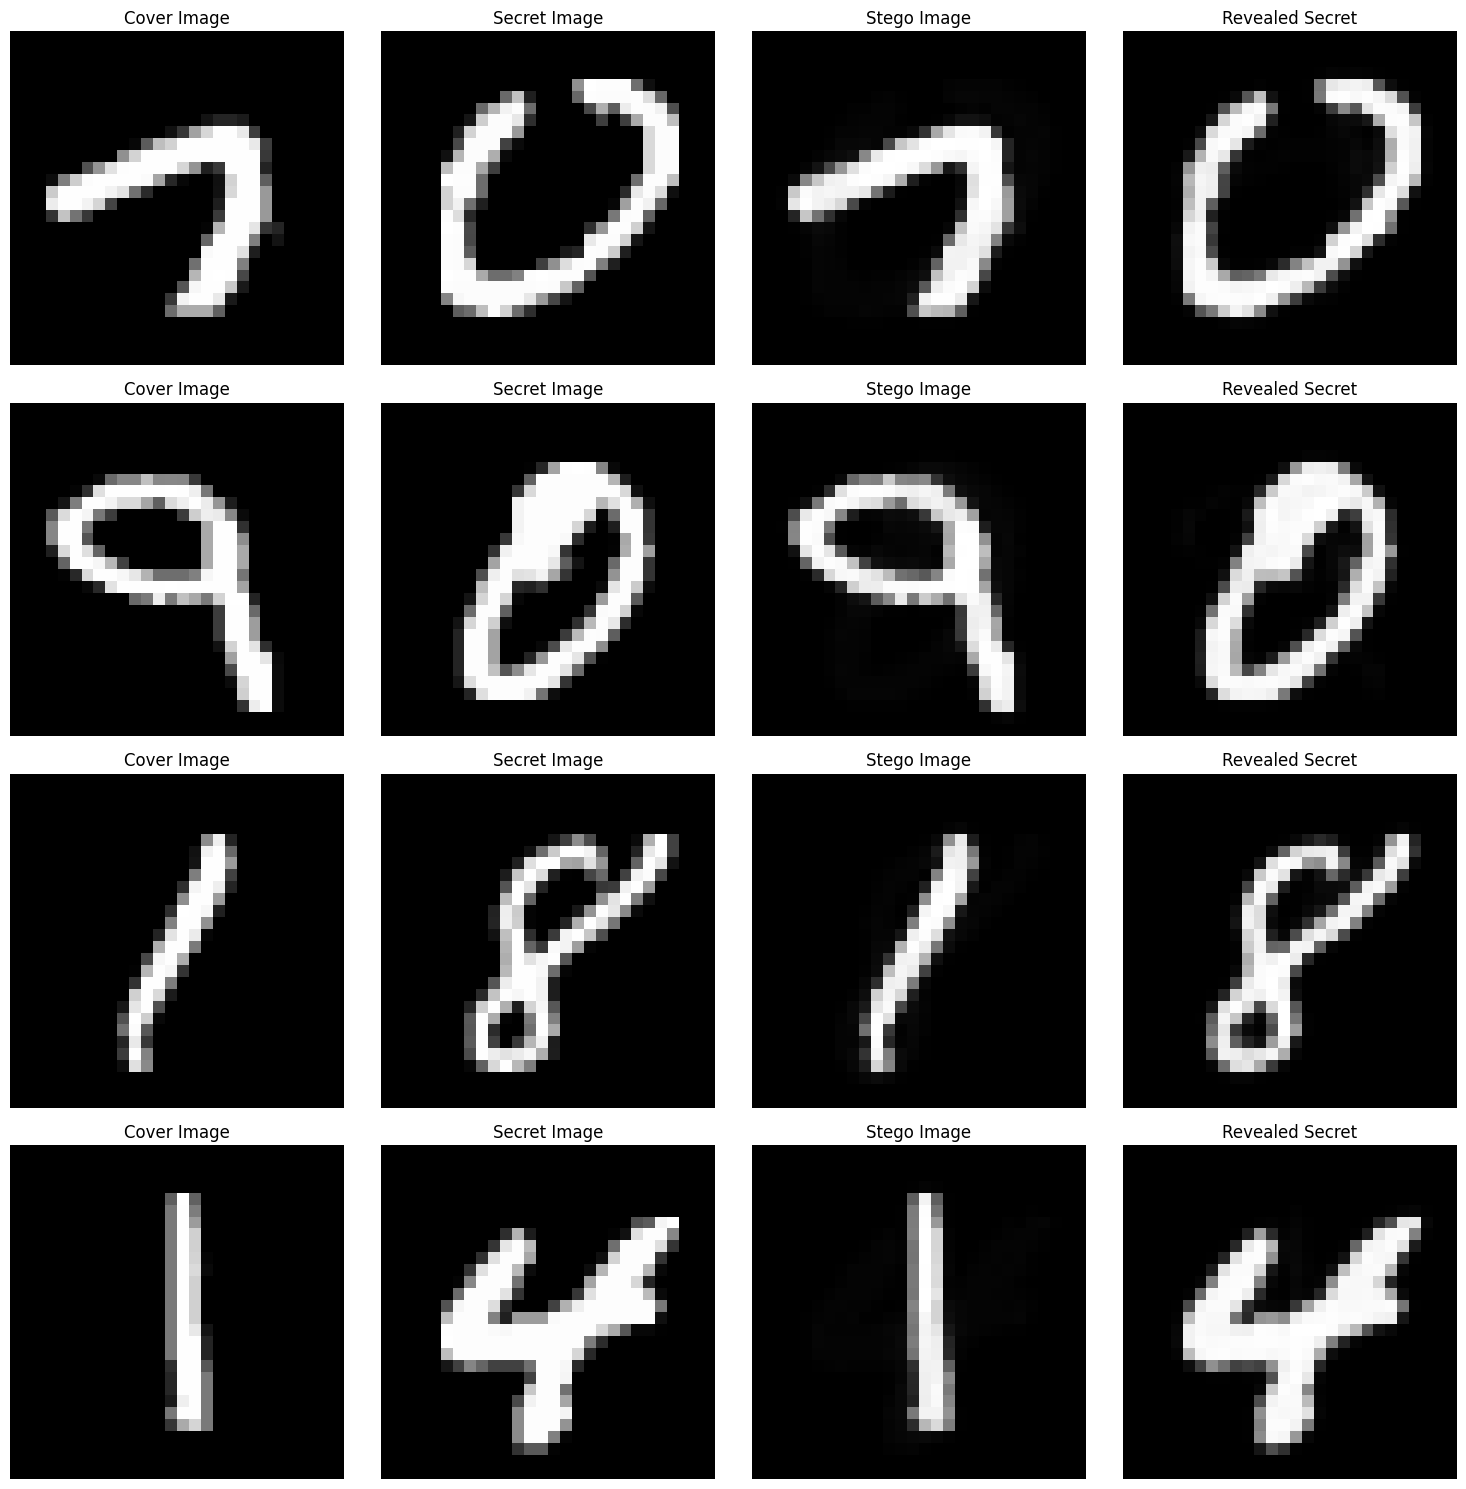

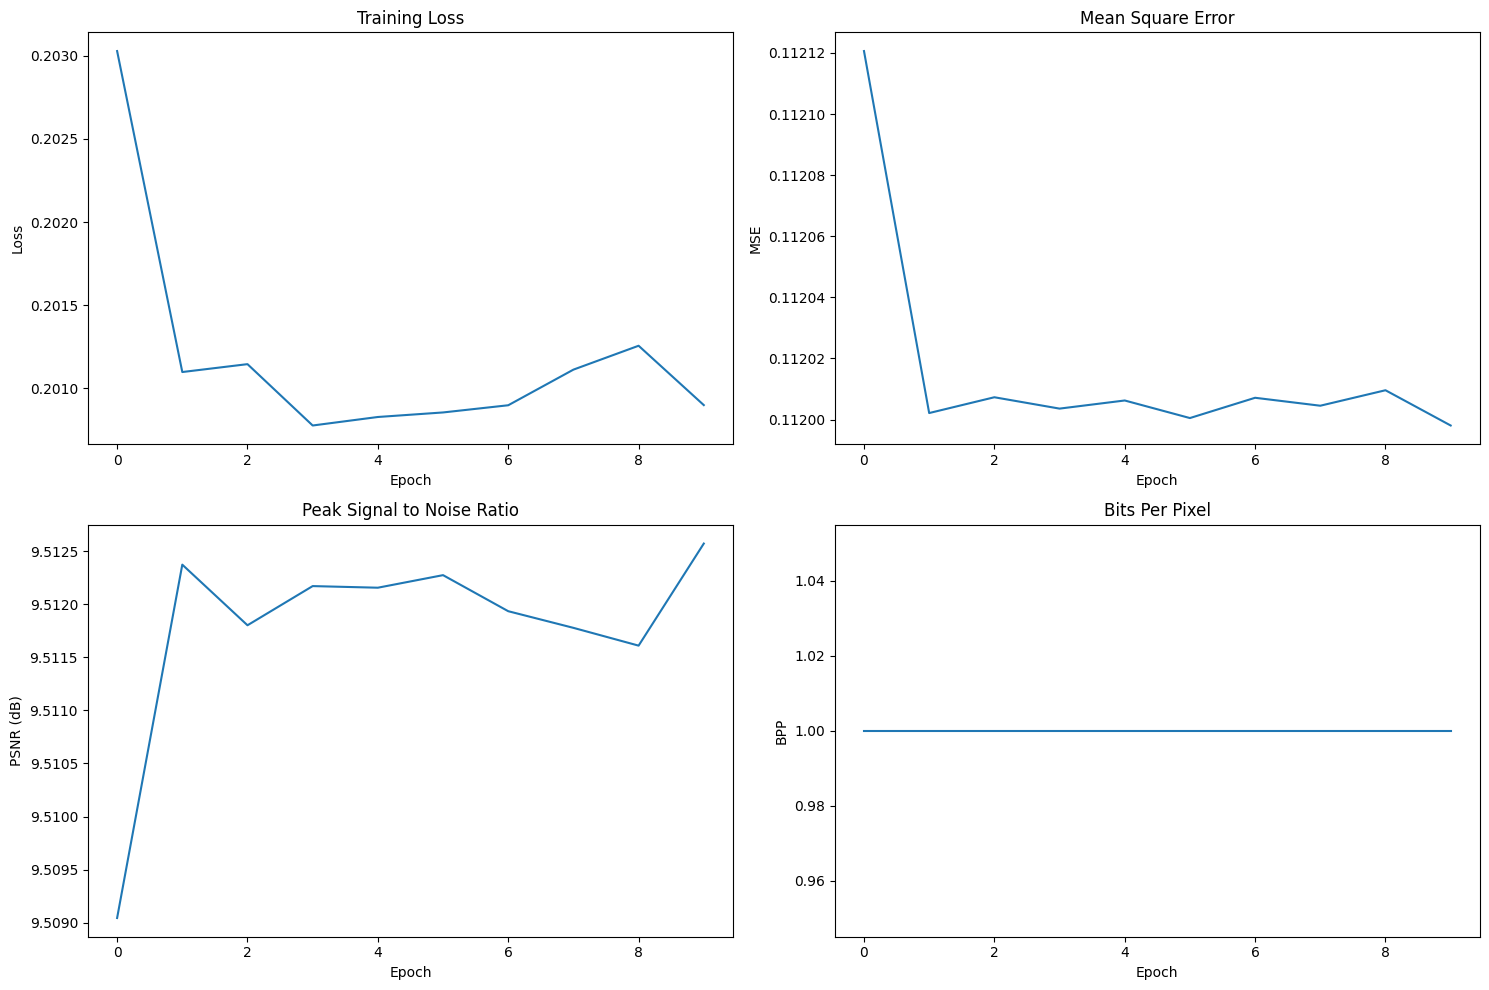

In [40]:
# Visualize results
visualize_results(model, train_loader)

# Plot training metrics
plot_metrics(metrics_history)